## 1. Transfer Learning for Image Classification

### In this problem, we are trying to build a classifier that distinguishes images of nine types of waste.

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras import layers, models, regularizers
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet101_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# Check for GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU devices found:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
DATA_DIR = "../data/RealWaste"
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR = "/content/drive/MyDrive/data/RealWaste"
IMG_SIZE = 224
EPOCHS = 100
BATCH_SIZE = 5
SEED = 42

BASE_MODEL_FN = {
    'efficientnet': EfficientNetB0,
    'resnet50': ResNet50,
    'resnet101': ResNet101,
    'vgg16': VGG16
}

Mounted at /content/drive


In [ ]:
def load_images_split(path, img_size=224):
    X_train, y_train = [], []
    X_test, y_test = [], []

    for class_name in sorted(os.listdir(path)):
        class_path = os.path.join(path, class_name)
        if not os.path.isdir(class_path): continue

        image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
        n = len(image_files)
        if n == 0:
            print(f"Warning: No valid images found in {class_path}")
            continue

        split_idx = int(0.8 * n)

        for idx, file in enumerate(image_files):
            img = cv2.imread(os.path.join(class_path, file))

            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                if idx < split_idx:
                    X_train.append(img)
                    y_train.append(class_name)
                else:
                    X_test.append(img)
                    y_test.append(class_name)

    if not X_train:
        raise ValueError("No valid images were loaded. Check the data directory and ensure it contains images.")

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [ ]:
# Load and split images to training and testing sets
X_train_full, y_train_full, X_test, y_test = load_images_split(DATA_DIR, IMG_SIZE)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_full)
y_test_encoded = label_encoder.transform(y_test)
# One-hot Encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded)

# Create of validation set
X_train, y_train, X_val, y_val = [], [], [], []

for class_index in range(len(label_encoder.classes_)):
    idxs = np.where(np.argmax(y_train_onehot, axis=1) == class_index)[0]
    val_size = int(0.2 * len(idxs))
    val_idxs = np.random.choice(idxs, val_size, replace=False)
    train_idxs = list(set(idxs) - set(val_idxs))

    X_val.extend(X_train_full[val_idxs])
    y_val.extend(y_train_onehot[val_idxs])
    X_train.extend(X_train_full[train_idxs])
    y_train.extend(y_train_onehot[train_idxs])

# Convert to arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
# Data augmentation for training
def get_data_generators(model_key, X_train, y_train, X_val, y_val, X_test, y_test, batch_size):
    PREPROCESS_FN = {
        'resnet50': resnet50_preprocess,
        'resnet101': resnet101_preprocess,
        'efficientnet': efficientnet_preprocess,
        'vgg16': vgg16_preprocess
    }

    preprocess_func = PREPROCESS_FN.get(model_key)
    if preprocess_func is None:
        raise ValueError(f"Invalid model_key '{model_key}'. Must be one of {list(PREPROCESS_FN.keys())}.")

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_func,
        rotation_range=30,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8, 1.2]
    )

    # Only preprocessing for validation and test
    val_test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_func
    )

    train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_gen = val_test_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_gen = val_test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

    return train_gen, val_gen, test_gen

In [ ]:
def build_model(base_model_fn, input_shape, num_classes):
    base_model = base_model_fn(include_top=False,
                               weights='imagenet',
                               input_shape=input_shape
                               )

    base_model.trainable = False  # Ensure base model is not trainable

    x = layers.Input(shape=input_shape)
    z = base_model(x)
    z = layers.GlobalAveragePooling2D()(z)
    z = layers.BatchNormalization()(z)
    z = layers.Dense(512,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(z)
    z = layers.Dropout(0.2)(z)
    # Second dense layer for additional complexity
    z = layers.Dense(256, activation='relu')(z)

    out = layers.Dense(num_classes, activation='softmax')(z)
    model = models.Model(inputs=x, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy']
                  )
    return model

def get_callbacks(model_name):
    return [
    EarlyStopping(monitor='val_loss', patience=15, min_delta=1e-4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

In [ ]:
def evaluate_split_set(model, X, y, label_encoder, model_name="Model", split_name="Split"):

    if y.ndim > 1 and y.shape[1] > 1:
        y = np.argmax(y, axis=1)

    y_labels = label_encoder.classes_[y]
    y_true = label_encoder.transform(y_labels)

    probs = model.predict(X, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_onehot = np.eye(len(label_encoder.classes_))[y_true]
    auc = roc_auc_score(y_onehot, probs, multi_class='ovr', average='macro')

    print(f"\n{model_name} - {split_name} Classification Report")
    print(classification_report(y_true, preds, target_names=label_encoder.classes_))
    print(f"{model_name} - {split_name} AUC Score: {auc:.4f}")

def evaluate_model(model, history, test_gen, label_encoder, model_name,
                   X_train=None, y_train=None, X_val=None, y_val=None):

    # === Plot Loss and Accuracy ===
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_name} - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{model_name} - Accuracy")
    plt.legend()
    plt.show()

    # Train and Val set results
    if X_train is not None and y_train is not None:
      evaluate_split_set(model, X_train, y_train, label_encoder, model_name, "Train")

    if X_val is not None and y_val is not None:
        evaluate_split_set(model, X_val, y_val, label_encoder, model_name, "Validation")

    # === Evaluate Test Set from Generator ===
    print(f"\n{model_name} - Test Evaluation")
    y_test_raw = np.concatenate([test_gen[i][1] for i in range(len(test_gen))])
    X_test_all = np.concatenate([test_gen[i][0] for i in range(len(test_gen))])

    if y_test_raw.ndim > 1 and y_test_raw.shape[1] > 1:
        y_test_true = label_encoder.inverse_transform(np.argmax(y_test_raw, axis=1))
    else:
        y_test_true = y_test_raw

    y_test_true = label_encoder.transform(y_test_true)
    y_test_probs = model.predict(X_test_all, verbose=0)
    y_test_pred = np.argmax(y_test_probs, axis=1)

    print(classification_report(
        y_test_true,
        y_test_pred,
        target_names=label_encoder.classes_
    ))

    y_test_onehot = np.eye(len(label_encoder.classes_))[y_test_true]
    test_auc = roc_auc_score(y_test_onehot, y_test_probs, multi_class='ovr', average='macro')
    print(f"{model_name} - Test AUC Score: {test_auc:.4f}")

    # === Confusion Matrix
    cm = confusion_matrix(y_test_true, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(xticks_rotation=45)
    plt.show()


In [ ]:
y_train_flat = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flat),
    y=y_train_flat
)
class_weight_dict = dict(enumerate(class_weights))

In [18]:
efficientnet_train_gen, efficientnet_val_gen, efficientnet_test_gen = get_data_generators(
    model_key='efficientnet',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test, y_test=y_test,
    batch_size=BATCH_SIZE
)
efficientnet_model = build_model(EfficientNetB0, (IMG_SIZE, IMG_SIZE, 3), y_train.shape[1])
efficient_net_history = efficientnet_model.fit(
    efficientnet_train_gen,
    validation_data=efficientnet_val_gen,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=get_callbacks('efficientnetb0')
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


609/609 ━━━━━━━━━━━━━━━━━━━━ 77s 93ms/step - accuracy: 0.2788 - loss: 2.1541 - val_accuracy: 0.5291 - val_loss: 1.5998 - learning_rate: 5.0000e-05
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.5566 - loss: 1.5129 - val_accuracy: 0.6534 - val_loss: 1.3716 - learning_rate: 5.0000e-05
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.6352 - loss: 1.3668 - val_accuracy: 0.7143 - val_loss: 1.2819 - learning_rate: 5.0000e-05
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.6801 - loss: 1.2787 - val_accuracy: 0.7222 - val_loss: 1.2330 - learning_rate: 5.0000e-05
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.6935 - loss: 1.2191 - val_accuracy: 0.7315 - val_loss: 1.2425 - learning_rate: 5.0000e-05
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.7136 - loss: 1.1982 - val_accuracy: 0.7368 - val_loss: 1.2288 - learning_rate: 5.0000e-05
Epoch 7/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - a

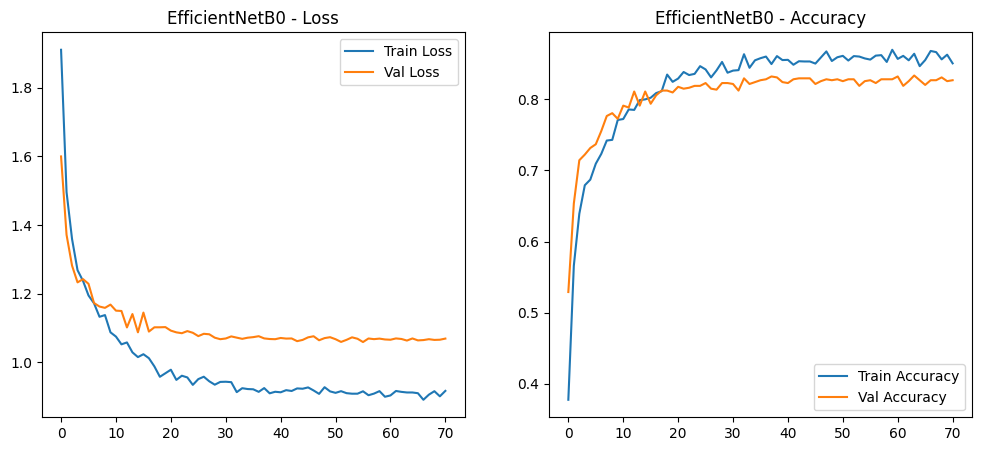


EfficientNetB0 - Train Classification Report
                       precision    recall  f1-score   support

          1-Cardboard       0.87      0.98      0.93       295
      2-Food Organics       0.95      0.99      0.97       263
              3-Glass       0.86      0.97      0.91       269
              4-Metal       0.91      0.94      0.93       506
5-Miscellaneous Trash       0.97      0.87      0.92       317
              6-Paper       0.94      0.97      0.96       320
            7-Plastic       0.96      0.81      0.88       589
      8-Textile Trash       0.91      1.00      0.95       204
         9-Vegetation       1.00      0.98      0.99       279

             accuracy                           0.93      3042
            macro avg       0.93      0.95      0.94      3042
         weighted avg       0.93      0.93      0.93      3042

EfficientNetB0 - Train AUC Score: 0.9981

EfficientNetB0 - Validation Classification Report
                       precision    reca

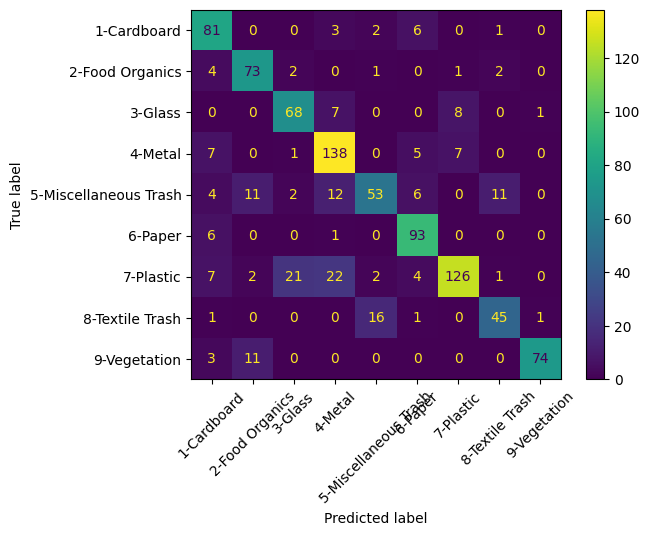

In [19]:
evaluate_model(
    model=efficientnet_model,
    history=efficient_net_history,
    test_gen=efficientnet_test_gen,
    label_encoder=label_encoder,
    model_name="EfficientNetB0",
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

In [ ]:
resnet_50_train_gen, resnet_50_val_gen, resnet_50_test_gen = get_data_generators(
    model_key='resnet50',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    batch_size=BATCH_SIZE
)
resnet_50_model = build_model(BASE_MODEL_FN['resnet50'], (IMG_SIZE, IMG_SIZE, 3), y_train.shape[1])
resnet_50_history = resnet_50_model.fit(
    resnet_50_train_gen,
    validation_data=resnet_50_val_gen,
    epochs=EPOCHS,
    callbacks=get_callbacks('resnet50')
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


609/609 ━━━━━━━━━━━━━━━━━━━━ 64s 85ms/step - accuracy: 0.3076 - loss: 2.1112 - val_accuracy: 0.6614 - val_loss: 1.3490 - learning_rate: 5.0000e-05
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.5982 - loss: 1.4589 - val_accuracy: 0.7156 - val_loss: 1.2533 - learning_rate: 5.0000e-05
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.6576 - loss: 1.3346 - val_accuracy: 0.7288 - val_loss: 1.2212 - learning_rate: 5.0000e-05
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.6956 - loss: 1.2656 - val_accuracy: 0.7646 - val_loss: 1.1691 - learning_rate: 5.0000e-05
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.7258 - loss: 1.2096 - val_accuracy: 0.7857 - val_loss: 1.1486 - learning_rate: 5.0000e-05
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.7404 - loss: 1.1925 - val_accuracy: 0.7778 - val_loss: 1.1625 - learning_rate: 5.0000e-05
Epoch 7/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - a

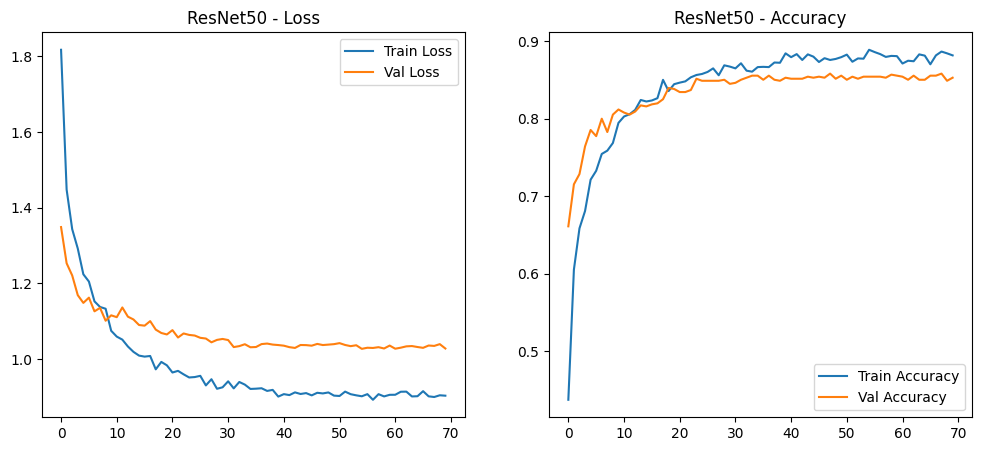


ResNet50 - Train Classification Report
                       precision    recall  f1-score   support

          1-Cardboard       0.52      0.88      0.65       295
      2-Food Organics       0.86      0.30      0.44       263
              3-Glass       0.71      0.81      0.76       269
              4-Metal       0.86      0.80      0.83       506
5-Miscellaneous Trash       0.49      0.64      0.56       317
              6-Paper       0.75      0.68      0.71       320
            7-Plastic       0.73      0.76      0.74       589
      8-Textile Trash       0.75      0.76      0.76       204
         9-Vegetation       0.97      0.53      0.68       279

             accuracy                           0.70      3042
            macro avg       0.74      0.68      0.68      3042
         weighted avg       0.74      0.70      0.70      3042

ResNet50 - Train AUC Score: 0.9557

ResNet50 - Validation Classification Report
                       precision    recall  f1-score   sup

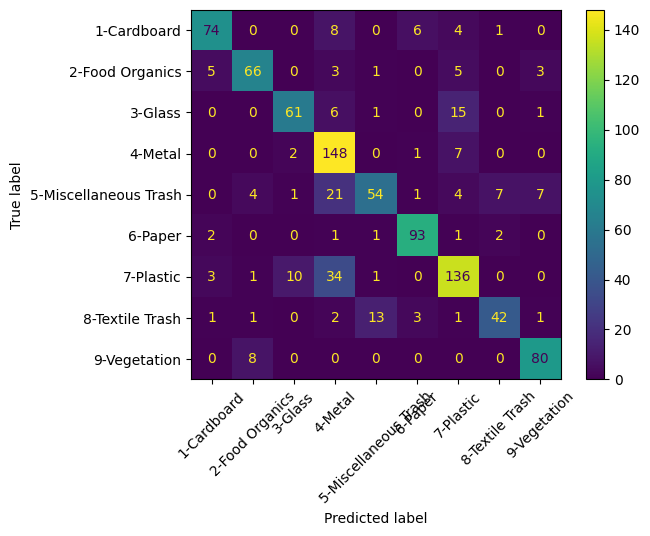

In [ ]:
evaluate_model(
    model=resnet_50_model,
    history=resnet_50_history,
    test_gen=resnet_50_test_gen,
    label_encoder=label_encoder,
    model_name="ResNet50",
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

In [ ]:
resnet_101_train_gen, resnet_101_val_gen, resnet_101_test_gen = get_data_generators(
    model_key='resnet101',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    batch_size=BATCH_SIZE
)
resnet_101_model = build_model(BASE_MODEL_FN['resnet101'], (IMG_SIZE, IMG_SIZE, 3), y_train.shape[1])
resnet_101_history = resnet_101_model.fit(
    resnet_101_train_gen,
    validation_data=resnet_101_val_gen,
    epochs=EPOCHS,
    callbacks=get_callbacks('resnet101')
)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


609/609 ━━━━━━━━━━━━━━━━━━━━ 76s 93ms/step - accuracy: 0.3355 - loss: 2.0080 - val_accuracy: 0.6296 - val_loss: 1.4108 - learning_rate: 5.0000e-05
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.6090 - loss: 1.4452 - val_accuracy: 0.6918 - val_loss: 1.3004 - learning_rate: 5.0000e-05
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.6848 - loss: 1.3172 - val_accuracy: 0.7235 - val_loss: 1.2341 - learning_rate: 5.0000e-05
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.7044 - loss: 1.2422 - val_accuracy: 0.7354 - val_loss: 1.2141 - learning_rate: 5.0000e-05
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.7153 - loss: 1.2384 - val_accuracy: 0.7394 - val_loss: 1.2188 - learning_rate: 5.0000e-05
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.7339 - loss: 1.1759 - val_accuracy: 0.7540 - val_loss: 1.2130 - learning_rate: 5.0000e-05
Epoch 7/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - a

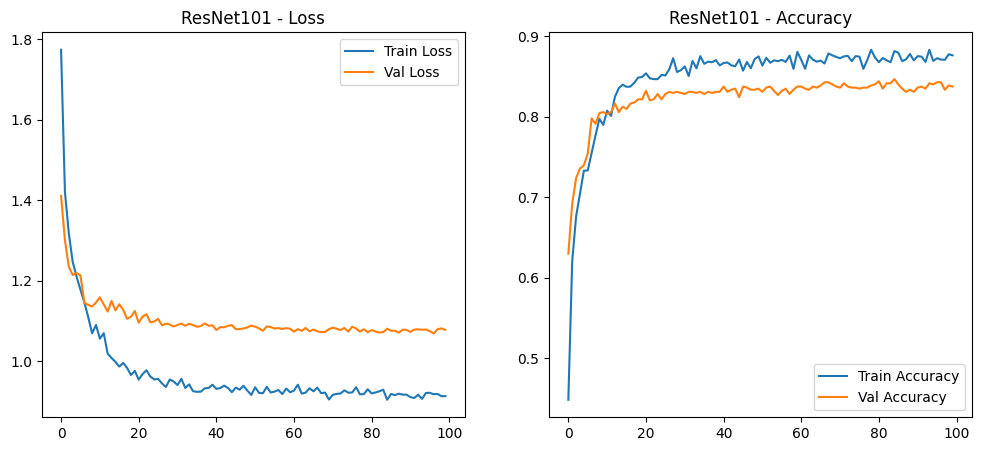


ResNet101 - Train Classification Report
                       precision    recall  f1-score   support

          1-Cardboard       0.43      0.84      0.57       295
      2-Food Organics       0.93      0.32      0.48       263
              3-Glass       0.53      0.90      0.67       269
              4-Metal       0.85      0.74      0.79       506
5-Miscellaneous Trash       0.64      0.52      0.57       317
              6-Paper       0.75      0.67      0.71       320
            7-Plastic       0.74      0.70      0.72       589
      8-Textile Trash       0.88      0.52      0.66       204
         9-Vegetation       0.91      0.84      0.87       279

             accuracy                           0.68      3042
            macro avg       0.74      0.67      0.67      3042
         weighted avg       0.74      0.68      0.68      3042

ResNet101 - Train AUC Score: 0.9589

ResNet101 - Validation Classification Report
                       precision    recall  f1-score   

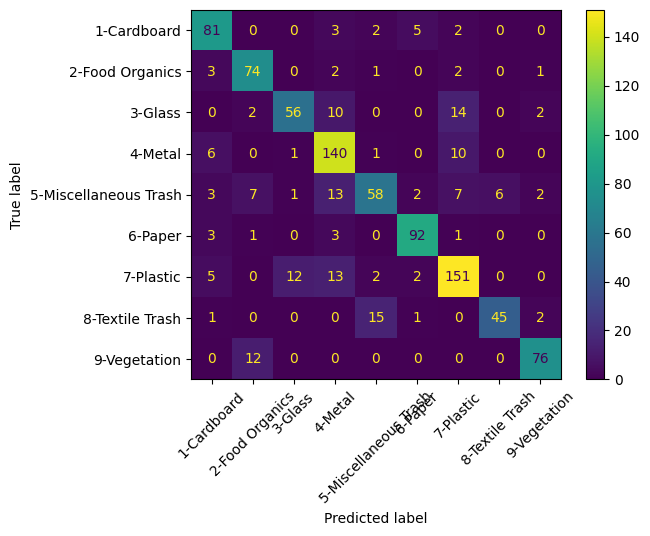

In [ ]:
evaluate_model(
    model=resnet_101_model,
    history=resnet_101_history,
    test_gen=resnet_101_test_gen,
    label_encoder=label_encoder,
    model_name="ResNet101",
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

In [16]:
vgg_train_gen, vgg_val_gen, vgg_test_gen = get_data_generators(
    model_key='vgg16',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    batch_size=BATCH_SIZE
)
vgg_model = build_model(BASE_MODEL_FN['vgg16'], (IMG_SIZE, IMG_SIZE, 3), y_train.shape[1])
vgg_history = vgg_model.fit(
    vgg_train_gen,
    validation_data=vgg_val_gen,
    epochs=EPOCHS,
    callbacks=get_callbacks('vgg16')
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


609/609 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2268 - loss: 2.1963 - val_accuracy: 0.5013 - val_loss: 1.6193 - learning_rate: 5.0000e-05
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.4714 - loss: 1.6848 - val_accuracy: 0.5966 - val_loss: 1.4606 - learning_rate: 5.0000e-05
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.5562 - loss: 1.5371 - val_accuracy: 0.6455 - val_loss: 1.3554 - learning_rate: 5.0000e-05
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.5746 - loss: 1.4860 - val_accuracy: 0.6799 - val_loss: 1.3065 - learning_rate: 5.0000e-05
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.6165 - loss: 1.4319 - val_accuracy: 0.6878 - val_loss: 1.2914 - learning_rate: 5.0000e-05
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.6127 - loss: 1.4066 - val_accuracy: 0.7063 - val_loss: 1.2612 - learning_rate: 5.0000e-05
Epoch 7/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - a

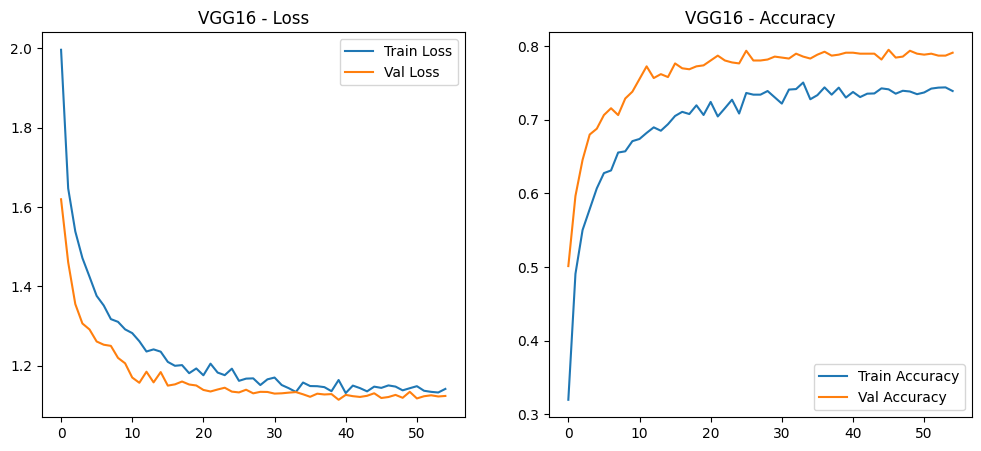


VGG16 - Train Classification Report
                       precision    recall  f1-score   support

          1-Cardboard       0.72      0.64      0.68       295
      2-Food Organics       0.88      0.32      0.46       263
              3-Glass       0.78      0.44      0.56       269
              4-Metal       0.82      0.71      0.76       506
5-Miscellaneous Trash       0.41      0.63      0.50       317
              6-Paper       0.73      0.69      0.71       320
            7-Plastic       0.59      0.84      0.69       589
      8-Textile Trash       0.68      0.65      0.67       204
         9-Vegetation       0.91      0.86      0.88       279

             accuracy                           0.67      3042
            macro avg       0.72      0.64      0.66      3042
         weighted avg       0.71      0.67      0.67      3042

VGG16 - Train AUC Score: 0.9391

VGG16 - Validation Classification Report
                       precision    recall  f1-score   support

   

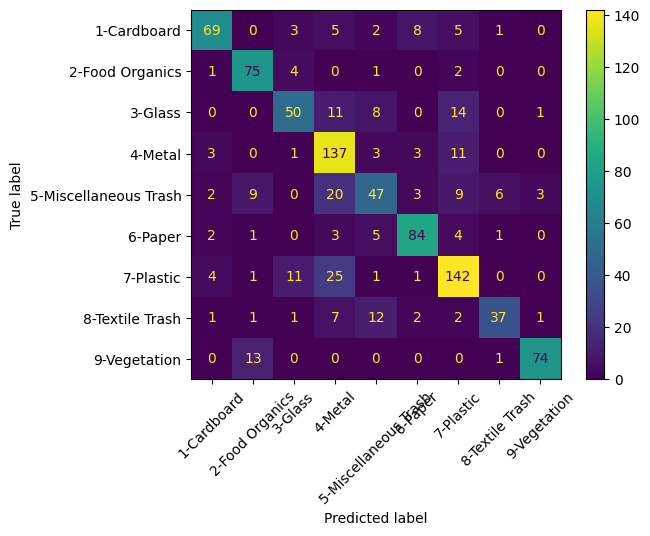

In [17]:
evaluate_model(
    model=vgg_model,
    history=vgg_history,
    test_gen=vgg_test_gen,
    label_encoder=label_encoder,
    model_name="VGG16",
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

# Comparison

All models test accuracy is almost similar.
EfficientNetB0 is the best-performing and most consistent model across all datasets (train, validation, test) for this multi-class classification task, with a strong balance of accuracy, macro F1, AUC, and generalization ability.